<a href="https://colab.research.google.com/github/kevinmcmanus/Astrophysics/blob/master/numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `numpy` for Data Scientists

In here, we'll illustrate just a tiny fraction of the capabilities of `numpy`, Python's library for scientific and mathematical computing. Data Scientists use `numpy` extensively in data wrangling, exploratory data analysis and modeling. `numpy` is fast, efficient and capable as you shall soon see.

The data and examples included here come from an Astronomy project concerning the Pleiades star cluster, visible on winter nights to the right of Orion's belt. We'll give you a little astronomy background so that you'll have some context, but the main intent is to demonstrate the capabilities of `numpy` so that you can apply them to your domain.

In [2]:
#Every notebook should start with this! 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# read data files into pandas dataframes

pleiades = pd.read_csv( 'https://focods.s3.us-east-2.amazonaws.com/search_results_Pleiades.csv')


In [4]:
pleiades.head()

,source_id,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe,r_est
0,3304955829373336960,60.608505,12.441081,5.891200,-3.018903,-12.335578,NaN,17.222012,18.800950,15.979157,1.100021,169.744698
1,179080177531845760,66.452059,38.007276,5.891232,26.641966,-16.450952,NaN,13.209787,13.859010,12.433570,1.014563,169.743775
2,3303051264779013760,59.697445,10.830024,5.891240,16.532691,-6.193089,NaN,20.534763,21.708458,19.178095,1.031617,169.743541
3,16238416647790336,50.814492,11.328204,5.891302,70.603479,-60.480058,NaN,18.818357,21.024681,17.385162,1.005758,169.741774
4,235767080050353920,49.186412,39.277634,5.891311,8.340712,-20.362997,NaN,17.922316,19.712795,16.639270,1.019833,169.741502


The data frame above is the result of searching the Gaia database for stars within a certain radius of the Pleiades' center. Gaia is a space-based telescope and its database includes observations for over 1.7 billion stars.  The data frame has one record for each star in the search results.

The data frame columns are as follows:

|Column Name|Description|
| --- | --- |
|source_id|Unique identifier for each star|
|ra|right ascension - longitude in the sky (degrees)|
|dec| declination - latitude in the sky (degrees)|
|parallax|parallax angle (milliarcseconds)|
|pmra|proper motion in right ascension (mas/year)
|pmdec|proper motion in declinatin (mas/year)
|radial_velocity| motion toward or away from observer (km/s)
|phot_g_mean_mag| apparent brightness (mag)
|phot_bp_mean_mag| apparent brightness through blue filter (mag)
|phot_rp_mean_mag| apparent brightness through red filter (mag)
|ruwe| measure of quality of observation, less is more
|r_est| estimated distance of object from earth/sun (parsec)

## Element-wise Trig Operations

We'll illustrate some element-wise operations using coordinate transformations as motivating examples.

### Spherical to Cartesian Coordinates

In here, we'll demonstrate some basic trig operations by converting spherical coordinates to cartesian and back again. We'll show how to make a result periodic.

* spherical coords typically specified as $(r, \phi, \theta)$
    * r: distance from origin
    * $\phi$ angle in plane of equator wrt zero line
    * $\theta$ elevation angle above equator, **measured from North Pole**
* earth/sun at center
* $RA_0$ points to vernal equinox
* $\phi$ = $RA$ denoted $\alpha$
* $\delta$ is complement of $\theta$, that is $\theta = 90^\circ - \delta$ called **declination**

Then

\begin{align*}
x  & = r\ sin(\theta)\ cos(\phi) \\y &= r\ sin(\theta)\ sin(\phi)\\z &= r\ cos(\theta)
\end{align*}

Note: $\delta = \frac{\pi}{2} - \theta$ then $cos\ \theta =\ sin(\frac{\pi}{2} - \theta) = sin(\delta)$ and similarly  $sin\ \theta =\ cos(\frac{\pi}{2} - \theta) = cos(\delta)$ so we can ditch the $\theta$ term above and measure up from the equator like normal people. Rewrite the transformation as:

\begin{align*}
x  & = r\ cos(\delta)\ cos(\alpha) \\y &= r\ cos(\delta)\ sin(\alpha)\\z &= r\ sin(\delta)
\end{align*}

which gives us Cartesian coordinates in terms of right ascension $\alpha$, declination $\delta$ and distance $r$.

Rewrite again as:
$$
\mathbf{R}\ =\ 
\begin{bmatrix} x\\ y \\z \end{bmatrix} =  
 r  \begin{bmatrix} cos\delta\cos\alpha \\ cos\delta\sin\alpha \\sin\delta \end{bmatrix}
$$


In [82]:
def spherical_to_cartesian(alpha, delta, r):
  """
  Returns 3xN cartesian coords from alpha, delta and r
  Alpha, Delta in degrees, r in some unit of length, here assumed to be parsec
  return value has one row each for {x,y,z} in that order
  """
  # convert degrees to radians
  alpha_rad = np.radians(alpha)
  delta_rad = np.radians(delta)

  #do the transformation
  x = r * np.cos(delta_rad)*np.cos(alpha_rad)
  y = r * np.cos(delta_rad)*np.sin(alpha_rad)
  z = r * np.sin(delta_rad)
  
  #package up and return
  xyz = np.array([x, y, z])
  return xyz

In [7]:
pleiades_xyz = spherical_to_cartesian(pleiades.ra, pleiades.dec, pleiades.r_est)

In [8]:
pleiades_xyz.shape

(3, 47625)

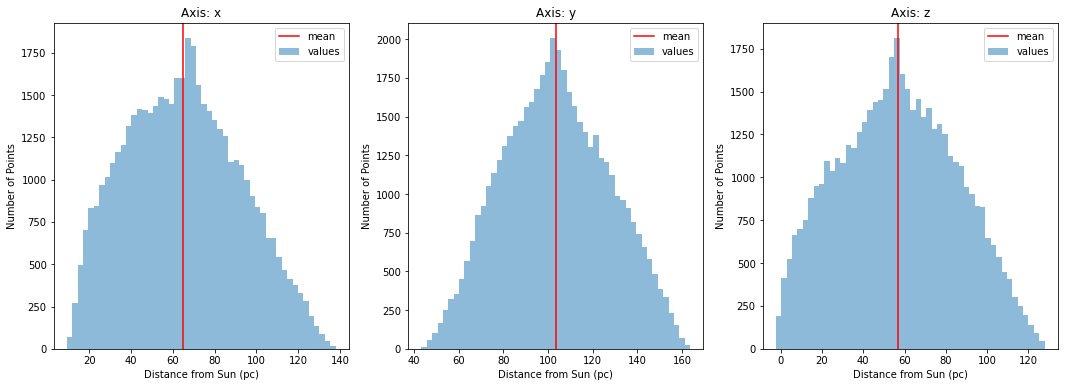

In [14]:
#look at the distribution of xyz values versus their respective means:
center = pleiades_xyz.mean(axis=1)
fig = plt.figure(figsize=(18,6))
ax = fig.subplots(1,3)
for i,d in enumerate(list('xyz')):
  ax[i].hist(pleiades_xyz[i],bins=50, label='values', alpha=0.5)
  ax[i].axvline(center[i], label='mean', color='red')
  ax[i].set_title(f'Axis: {d}')
  ax[i].set_ylabel('Number of Points')
  ax[i].set_xlabel('Distance from Sun (pc)')
  ax[i].legend()


### Cartesian to Spherical

Here's how:

\begin{align*}
\alpha &= arctan2(y, x) \\
\delta &= arctan(z/\sqrt{x^2 + y^2}) \\
r &= \sqrt{x^2 + y^2 + z^2}
\end{align*}


In [9]:
def cartesian_to_spherical(xyz):
  """
  converts cartesian coords to spherical
  Argument:
    xyz: 3xN array where x is row 0, y row 1  and z row 2
  Returns:
    dictionary with members distance, alpha and delta
  """

  #calculate r, the Euclidean distance from origin
  r = np.sqrt((xyz**2).sum(axis=0))
  
  #calculate delta or declination (latitude), result between -pi/2 and pi/2
  delta = np.arctan(xyz[2]/np.sqrt(xyz[0]**2+xyz[1]**2))
  
  #calculate alpha or right ascension(longitude), result between 0 and pi
  #(3rd and 4th quadrants returned as <0)
  alpha = np.arctan2(xyz[1], xyz[0])
  # deal with negative longitudes 
  alpha = np.remainder(alpha+2.0*np.pi, 2.0*np.pi)
    
  #make a dict for result, convert radians to degrees in the process
  spherical = {'distance':r,
                'alpha': np.rad2deg(alpha),
                'delta': np.rad2deg(delta)
  }
  
  return spherical
    

In [10]:
pleiades_spherical = cartesian_to_spherical(pleiades_xyz)

In [11]:
#did reverse transformation work?
(np.allclose(pleiades.ra,pleiades_spherical['alpha']),
np.allclose(pleiades.dec,pleiades_spherical['delta']),
np.allclose(pleiades.r_est,pleiades_spherical['distance']))

(True, True, True)

### Make the Result Periodic

The function above `cartesian_to_spherical` made use of `np.remainder`. Let's see what that does.

In [12]:
#what does np.remainder do?
zz=np.arange(-10,10)
zr = np.remainder(zz+5,5)
pd.DataFrame({'Input':zz, 'Output':zr})

,Input,Output
0,-10,0
1,-9,1
2,-8,2
3,-7,3
4,-6,4
5,-5,0
6,-4,1
7,-3,2
8,-2,3
9,-1,4


## Dealing with Differing Numbers of Dimensions

We will calculate each point's distance from another point, say a centertroid to illustrate dealing with arrays with differing numbers of dimensions. We'll show how to force `numpy` how to iterate over the dimension you want.

To illustrate, we will calculate each star's distance from a centerpoint as follows:

$$
d_i = \sqrt{(x_i-x_C)^2 + (y_i-y_C)^2 + (z_i-z_C)^2}
$$

for each star $i$ and center $C$

In [13]:
#quick & dirty centroid
# get mean xyz values (mean of each row)
center = pleiades_xyz.mean(axis=1)
center

array([ 65.11810819, 103.62271789,  56.79816511])

In [15]:
pleiades_xyz.shape, center.shape

((3, 47625), (3,))

### Quick Aside: Dealing with Arrays with Different Numbers of Dimensions

Suppose you have a 3x3 matrix and a 3 element vector. If you perform an operation with the two, will `numpy` iterate across the columns or down the rows?

In [16]:
# a 2d array
xx = np.array([[10,20,30],[40, 50, 60],[70,80,90]]);
xx

array([[10, 20, 30],
       [40, 50, 60],
       [70, 80, 90]])

In [17]:
#a 1d array
yy = np.array([5,15, 20])
yy

array([ 5, 15, 20])

In [18]:
xx.shape, yy.shape

((3, 3), (3,))

In [19]:
# can these be subtracted? (yes, but maybe not the way we want!!)
xx-yy

array([[ 5,  5, 10],
       [35, 35, 40],
       [65, 65, 70]])

In [20]:
#to force the operation the way we need it to  work,
# make yy a column vector
yy.reshape(-1,1)

array([[ 5],
       [15],
       [20]])

In [21]:
# now the subtraction works across the columns
xx-yy.reshape(-1,1)

array([[ 5, 15, 25],
       [25, 35, 45],
       [50, 60, 70]])

### Back to computing distance from Center

In [22]:
# Calculate Euclidean distance from Center
offsets = pleiades_xyz - center.reshape(-1,1) #to force correct broadcasting
distances = np.sqrt((offsets**2).sum(axis=0)) #note axis=0 for getting the sum by column
distances.shape

(47625,)

Text(0.5, 0, 'Distance from Center (pc)')

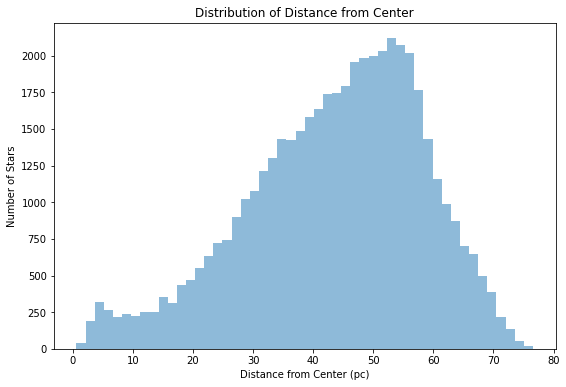

In [23]:
fig = plt.figure(figsize=(9,6))
ax = fig.subplots(1,1)

ax.hist(distances, bins=50, alpha=0.5)
ax.set_title('Distribution of Distance from Center')
ax.set_ylabel('Number of Stars')
ax.set_xlabel('Distance from Center (pc)')

## Element-wise Choice of Values: `np.where`



###Common Case: Dealing with NaN's

For reasons beyond our current scope, relatively few stars have radial velocity measurements. Perhaps we want to supply a value in cases in which there is no observed value.

In [24]:
pleiades.radial_velocity[:10]

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: radial_velocity, dtype: float64

In [25]:
print(f'Pleiades missing {np.count_nonzero(np.isnan(pleiades.radial_velocity))} rv values out of {len(pleiades)} observations')

Pleiades missing 41125 rv values out of 47625 observations


In [26]:
#convenient that the mean method ignores missing values
pleiades.radial_velocity.mean()

6.466343065772078

In [27]:
# stuff in the mean of the rv values that we have when rv is missing
mean_rv = pleiades.radial_velocity.mean()

rv_full = np.where(np.isnan(pleiades.radial_velocity), mean_rv, pleiades.radial_velocity)

In [28]:
np.count_nonzero(np.isnan(rv_full)), np.count_nonzero(rv_full == mean_rv)

(0, 41125)

### Common Case: Discontinuous Function

Sometimes functions are computed differently depending where in a domain an observation lies.
Suppose, for example:
\begin{align*}
y &= 3x\ +\ 2\ for\ x \leq -6 \\
y &= 4x\ +\ 8\ for\ x > -6

\end{align*}
and we want a fast and efficient way to calculate $y$. `np.where` will do the trick.

In [29]:
# create a range of x values
x=np.linspace(-10,10, 10000)
y1 = 3*x+2
y2 = 4*x+8

#use np.where to choose between the two y's
y = np.where(x <= -6, y1, y2)

Text(0.5, 1.0, 'Example of Discontinuous Function')

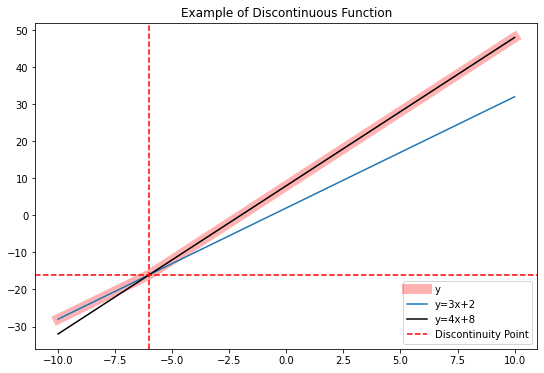

In [30]:
fig = plt.figure(figsize=(9,6))
ax = fig.subplots(1,1)


ax.plot(x,y, label='y', linewidth=10, alpha=0.3, color='red')
ax.plot(x,y1,label='y=3x+2')
ax.plot(x,y2, label='y=4x+8', color='black')


ax.axvline(-6, ls='dashed', color='red',label='Discontinuity Point')
ax.axhline(-16, ls='dashed', color='red')
ax.legend()
ax.set_title('Example of Discontinuous Function')

## Transposing and Reshaping

Usually, your data array is not in the shape you need it to be. Here's how to rearrange things.

### Simple Case

In [76]:
rng = np.arange(9)
rng


array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [83]:
#make an array whose values we can recognize
a = np.array([rng+10*i for i in range(9)])
a

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [10, 11, 12, 13, 14, 15, 16, 17, 18],
       [20, 21, 22, 23, 24, 25, 26, 27, 28],
       [30, 31, 32, 33, 34, 35, 36, 37, 38],
       [40, 41, 42, 43, 44, 45, 46, 47, 48],
       [50, 51, 52, 53, 54, 55, 56, 57, 58],
       [60, 61, 62, 63, 64, 65, 66, 67, 68],
       [70, 71, 72, 73, 74, 75, 76, 77, 78],
       [80, 81, 82, 83, 84, 85, 86, 87, 88]])

In [84]:
#reshape on the low order dimensions just grabs the next n values
a.reshape((-1,3,3))

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[10, 11, 12],
        [13, 14, 15],
        [16, 17, 18]],

       [[20, 21, 22],
        [23, 24, 25],
        [26, 27, 28]],

       [[30, 31, 32],
        [33, 34, 35],
        [36, 37, 38]],

       [[40, 41, 42],
        [43, 44, 45],
        [46, 47, 48]],

       [[50, 51, 52],
        [53, 54, 55],
        [56, 57, 58]],

       [[60, 61, 62],
        [63, 64, 65],
        [66, 67, 68]],

       [[70, 71, 72],
        [73, 74, 75],
        [76, 77, 78]],

       [[80, 81, 82],
        [83, 84, 85],
        [86, 87, 88]]])

In [85]:
#transpose rearranges the elements
a.transpose(1,0)

array([[ 0, 10, 20, 30, 40, 50, 60, 70, 80],
       [ 1, 11, 21, 31, 41, 51, 61, 71, 81],
       [ 2, 12, 22, 32, 42, 52, 62, 72, 82],
       [ 3, 13, 23, 33, 43, 53, 63, 73, 83],
       [ 4, 14, 24, 34, 44, 54, 64, 74, 84],
       [ 5, 15, 25, 35, 45, 55, 65, 75, 85],
       [ 6, 16, 26, 36, 46, 56, 66, 76, 86],
       [ 7, 17, 27, 37, 47, 57, 67, 77, 87],
       [ 8, 18, 28, 38, 48, 58, 68, 78, 88]])

In [86]:
#reshaping this gives a very different result
a.T.reshape(-1,3,3)

array([[[ 0, 10, 20],
        [30, 40, 50],
        [60, 70, 80]],

       [[ 1, 11, 21],
        [31, 41, 51],
        [61, 71, 81]],

       [[ 2, 12, 22],
        [32, 42, 52],
        [62, 72, 82]],

       [[ 3, 13, 23],
        [33, 43, 53],
        [63, 73, 83]],

       [[ 4, 14, 24],
        [34, 44, 54],
        [64, 74, 84]],

       [[ 5, 15, 25],
        [35, 45, 55],
        [65, 75, 85]],

       [[ 6, 16, 26],
        [36, 46, 56],
        [66, 76, 86]],

       [[ 7, 17, 27],
        [37, 47, 57],
        [67, 77, 87]],

       [[ 8, 18, 28],
        [38, 48, 58],
        [68, 78, 88]]])

### A More Complex Transformation

After some messy but straightforward Calculas, the derivative of $\mathbf{R}$ with respect to time is:

$$
\mathbf{\dot{R}} = 
  \begin{bmatrix} \frac{dx}{dt}\\\frac{dy}{dt}\\ \frac{dz}{dt}\end{bmatrix}\ =\ 
  \begin{bmatrix}
      \cos\alpha\sin\delta&-\sin\alpha & -\cos\alpha\sin\delta \\
       \sin\alpha\cos\delta &\cos\alpha & -\sin\alpha\sin\delta \\
       \sin\delta & 0 & \cos\delta \\ 
  \end{bmatrix}
  \begin{bmatrix}
      \dot{R} \\ R\dot{\alpha}\cos\delta \\ R\dot{\delta}
  \end{bmatrix}
 $$
 where the terms on the right side are: $\dot{R}$ is radial velocity, $R$ is distance from the observer, $\dot{\alpha}\cos\delta$ is proper motion in right ascension (`PMRA`), and $\dot{\delta}$ is proper motion in declination (`PMDec`). All of these quantities are available in the data frames we're working with.

Note, $\mathbf{\dot{R}}$ is usually expressed in $km s^{-1}$ so there's a conversion factor (not shown) to convert PMRA and PMDec from milli-arcseconds per year to kilometers per second.
Also, the Gaia Consortium (the data source) includes the $\cos\delta$ factor in its report of `PMRA` so we won't need to factor it in.

How can we calculate $\dot{\mathbf{R}}$ efficiently? In the function below, note the construction of the derivative matrix (variable `dm`) and its reshaping. Note also the matrix multiplication to produce the space velocities.

In [37]:
def pm_to_dxyz(alpha, delta, distance, pm_alpha_cosdec, pm_delta, radial_velocity):
  """
  Transforms proper motion & radial velocity to 3d space motion
  Arguments:
    alpha, delta: right ascension and declination in degrees
    distance: distance from observer in parsec
    pm_alpha_cosdec: proper motion in right ascension in mas/year including the cos(dec) term
    pm_dec: proper motion in declination in mas/year
    radial_velocity: in km/second
  Returns:
    3XN space velocity vector in km/second;
      one row for each {dx, dy, dz}
      one column for each star
  """
  # radial_velocity in km/sec, so need convert the motions to km/s

  mas_per_degree = 3.6e6
  km_per_pc = 3.09e13
  seconds_per_year = (60.0*60.0*24.0*365.0)

  #how many stars we got?
  N = len(alpha)

  #get some radians
  alpha_rad = np.radians(alpha)
  delta_rad = np.radians(delta)
  # the pm's are in milliarcseconds per year, so need to convert to degree per year
  pm_alpha_rad = np.radians(pm_alpha_cosdec/mas_per_degree)
  pm_delta_rad = np.radians(pm_delta/mas_per_degree)

  #convert the pm's from radian per year to km per sec
  v_ra =  pm_alpha_rad*distance*km_per_pc/seconds_per_year
  v_dec = pm_delta_rad*distance*km_per_pc/seconds_per_year
  
  #form the velocity matrix in spherical coords.
  # matrix is 3xN
  eq_v = np.array([radial_velocity,v_ra, v_dec])

  #form the derivative matrix
  sin_alpha = np.sin(alpha_rad); cos_alpha = np.cos(alpha_rad)
  sin_delta = np.sin(delta_rad); cos_delta = np.cos(delta_rad)
  #shape will be 9xN, one row for each term, 1 col for each star
  dm = np.array([cos_delta*cos_alpha, -sin_alpha,   -sin_delta*cos_alpha,
                cos_delta*sin_alpha,   cos_alpha,   -sin_alpha*sin_delta,
                sin_delta,             np.zeros(N),  cos_delta])
  #transpose and reshape in to N 3x3 matrices (a 3-d array)
  dm = dm.transpose(1,0).reshape(-1, 3, 3)
  
  #perform the transformation on each star individually
  d_xyz = np.array([dm[i].dot(eq_v[:,i].reshape(3,1)) for i in range(N)])

  #The dot product above yields an extra dimension that we don't need
  #also, the result has one row for each star, but we want the stars on the columns
  d_xyz = d_xyz.squeeze().transpose()
  
  #all done!
  return d_xyz

In [38]:
r_dot = pm_to_dxyz(pleiades.ra, pleiades.dec, pleiades.r_est, pleiades.pmra, pleiades.pmdec, rv_full)
r_dot.shape

(3, 47625)

Text(0.5, 1.0, 'Distribution of Space Velocities')

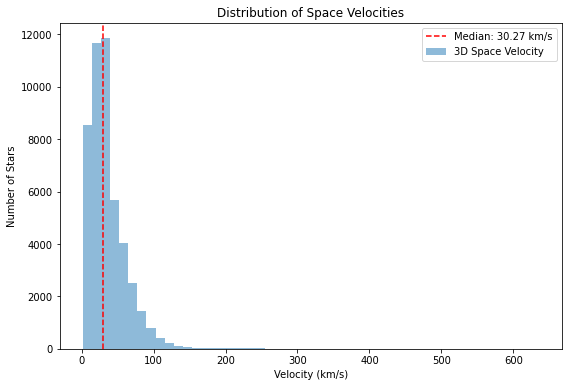

In [39]:
space_v_3d = np.sqrt((r_dot**2).sum(axis=0))
med_v = np.median(space_v_3d)

fig = plt.figure(figsize=(9,6))
ax = fig.subplots(1,1)


ax.hist(space_v_3d, label='3D Space Velocity', alpha=0.5, bins=50)
ax.axvline(med_v, ls='dashed',color='red', label = f'Median: {med_v:.2f} km/s')
ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Number of Stars')

ax.legend()
ax.set_title('Distribution of Space Velocities')

## More Matrix Multiplication

Having $\mathbf{R}$ and $\mathbf{\dot{R}}$ from above allows us to exptrapolate a star's position forward or backward in time via the following formula:

$$
\begin{align*}
\mathbf{R_t} &= \mathbf{R_0} + \Delta \mathbf{R} \\
\Delta \mathbf{R} &= \mathbf{\dot{R}}*\Delta t

\end{align*}
 $$

The following cells demonstrate how to calculate $\Delta\mathbf{R}$ for an arbitrary vector of time deltas and then calculates $\mathbf{R_t}$, that is the position at each of these arbitrary times.

Then we'll write a function that does this calculation efficiently for all of the stars we have.

In [40]:
# set up some values for demo purposes:

# time deltas (note: these are time offsets from  t=0)
# need these as row vector
delta_t = np.array([10,20,30,40]).reshape(1,-1) # row vector of years, let's say

#random 3d velocities as col vector
r_dot_demo = np.array([4.33, 8.32, 5.43]).reshape(3,1)

#initial position, r_zero
r_zero_demo = np.array([50,60,70]).reshape(3,1) # some random point in 3D space

In [41]:
#to get x,y,z positional changes:
#form dot product of 3x1 and 1xN to get 3xN, N=number of time deltas in this case
r_dot_demo.dot(delta_t)

array([[ 43.3,  86.6, 129.9, 173.2],
       [ 83.2, 166.4, 249.6, 332.8],
       [ 54.3, 108.6, 162.9, 217.2]])

In [42]:
# (x,y,z) position at each time delta
r_zero_demo + r_dot_demo.dot(delta_t)

array([[ 93.3, 136.6, 179.9, 223.2],
       [143.2, 226.4, 309.6, 392.8],
       [124.3, 178.6, 232.9, 287.2]])

In [54]:
def extrapolate_R(R, R_dot, delta_t):
  """
  Computes 3d positions at delta_t times
  Arguments:
    R: 3xN array of initial positions dimensions {x,y,z} x Star (parsec)
    R_dot: 3xN array of space velocity: {dx, dy, dz} x Star (km/s)
    delta_t: 1xNt vector of time deltas at which to compute the position
  Returns:
    R_t: Nx3xNt array of star positions: {Stars x {x,y,z} x delta_t}
  """

  assert R.shape == R_dot.shape

  N = R.shape[1] # number of stars
  Nt = len(delta_t) # number of time steps
  km_per_pc = 3.09e13 # kilometers per parsec
  seconds_per_year = (60.0*60.0*24.0*365.0)

  if delta_t.ndim == 1:
    dt = delta_t.reshape(1,-1)
  elif delta_t.ndim == 2:
    dt = delta_t
  else:
    raise ValueError(f'Invalid number of dims on delta_t: {delta_t.ndim}')

  #make R and R_dot into column vectors and convert R_dot from km/s to pc per year
  R_col = R.T.reshape(-1,1)
  R_dot_col = R_dot.T.reshape(-1,1)*seconds_per_year/km_per_pc

  #form positional changes
  delta_R = R_dot_col.dot(dt)
  R_t = R_col + delta_R

  #rearrange R_t to be (stars x {x,y,z} x time)
  R_t = R_t.reshape(N, 3, Nt)

  return R_t

In [55]:
#extrapolate teh stars over the last 100 Myr in steps of 1Mr
Nt = 100
delta_t = np.linspace(-100e6, 0, Nt+1)

#get initial positions and 3d velocities
R_0 = spherical_to_cartesian(pleiades.ra, pleiades.dec, pleiades.r_est)
R_dot = pm_to_dxyz(pleiades.ra, pleiades.dec, pleiades.r_est, pleiades.pmra, pleiades.pmdec, rv_full)

In [56]:
R_t = extrapolate_R(R_0, R_dot, delta_t)

In [77]:
#what did we get?
R_t.shape, R_t.size

((47625, 3, 101), 14430375)

In [78]:
#check Star #0, it's last extapolated position should be same as its starting position
#since delta_t runs from -100 Myr to 0 (present)
R_t[0,:,-1], R_0[:,0]

(array([ 81.35016122, 144.42340205,  36.56904037]),
 array([ 81.35016122, 144.42340205,  36.56904037]))

In [79]:
some_random_star = 555
R_0[:,some_random_star], R_t[some_random_star,:, -1]

(array([121.39575929,  77.74510277,  88.5948011 ]),
 array([121.39575929,  77.74510277,  88.5948011 ]))

In [73]:
np.random.seed(1234)

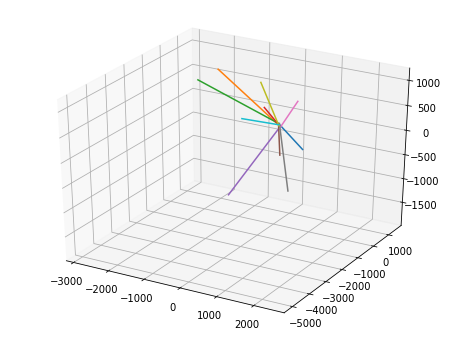

In [80]:
#make 3d plot for fun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#randomly pick a bunch of stars to plot in 3d
n_stars_to_plot = 10
star_i = np.random.choice(len(R_t), n_stars_to_plot, replace=False)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for s in star_i:
  #plot the x, y, and z coords, respectively
  ax.plot(R_t[s][0],R_t[s][1],R_t[s][2])

## Conclusions

`numpy` is powerful and efficient, featuring a vast range of capabilities only a few of which we demonstrated here.  Careful shaping and re-shaping of data array enables computations on large data sets while economizing computation time and code.

Here is a summary of the capabilities/functions we covered here:

| Function/Method | Notes |
| --- | --- |
|`np.where`| element-wise choice of value, useful for implementing discontinuities|
|`np.remainder`| produces periodic result |
|`np.allclose`| test whether two arrays have element-wise the same values|
|`np.radians`| converts degrees to radians; also inverse function `np.degrees`|
|`np.cos,` et. al.| every trig function imaginable|
|`np.transpose`| rearrange dimensions |
|`np.dot`| produces dot product or matrix product
|`np.reshape`| interprets the array in the shape specified
|`np.squeeze`| gets rid of a length-1 dimension
|`np.sum`, `np.mean` et. al.| compute all manner of summary statistics along specifiable dimensions.|
|`np.sqrt` et. al.| all manner of math functions, e.g. `log`, `log10` etc
|`np.random.choice`| make random selections with or without replacement|
|broadcasting| how `numpy` determines which dimensions to iterate over and how to force it to do the one you want
